# <span style='color:Green'> MSCI 446 - Fall 2020  </span>
## Term Project: Stock Value Prediction of Rival Tech Companies
### Nimisha Saxena & Defne Celebi 
--- 
##  <span style='color:Maroon'> 1. Data Collection  </span>
<p style='color:Gray'> Alpha Vantage API was leveraged to collect the required data for this project. It is a reliable API built by a community of engineers and researchers and supported by Y Combinator. [2] We chose this API as it is one of the leading providers of stock APIs as well as forex (FX) and digital/crypto currency data feeds. It’s idea is driven by rigorous research, cutting edge technology, and a disciplined focus on democratizing FREE access to data. </p>

In [1]:
import requests

#Company names

DATA = {
    'EComm': ['Walmart', 'Amazon'],
    'Payment': ['Mastercard', 'Visa'],
    'Streaming': ['Netflix', 'Disney'],
    'Biotech': ['Pfizer', 'Novavax']
}


In [ ]:
#Data collection
#Please don't run this block, as the data has already been extracted and added in the zip file
#API call also has a limitation of extracting a set data size in 1 minute, thus this part was performed in two sets by commenting our the Data dictionary.

for category in DATA.keys():
    for symb in DATA[category]:
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&outputsize=full&apikey=%20139FKF40WEK95OEA&datatype=csv'.format(symb)
        x = requests.get(url)
        with open('Data/{}/{}.csv'.format(category, symb), 'wb') as wr:
            wr.write(x.content)

##  <span style='color:Maroon'> 2. Convert to Timeseries Data  </span>
<p style='color:Gray'> In order to proceed, it was important to convert this dataset into time series format i.e. setting the indexes as dates. Time-series is a concept within statistical learning that allows analysts to derive information from the data over time. This fits our idea as the stocks are dictated by dates, thus using time-series would yield the best results when predicting future stocks.  </p>

In [2]:
#Converting stocks dataframe to timeseries

import pandas as pd
import matplotlib.pyplot as plt

data_dict = {}

for category in DATA.keys():
    for symb in DATA[category]:
        df = pd.read_csv('Data/{}/{}.csv'.format(category, symb))
        #setting index as date
        df['timestamp'] = pd.to_datetime(df.timestamp,format='%Y-%m-%d')
        df.index = df['timestamp']
        data_dict[symb] = df
        
print(data_dict.keys())

dict_keys(['Walmart', 'Amazon', 'Mastercard', 'Visa', 'Netflix', 'Disney', 'Pfizer', 'Novavax'])


##  <span style='color:Maroon'> 3. Filtering &amp; Cleaning Data  </span>
<p style='color:Gray'> After extraction, it was important to ensure that the data is correct, consistent and usable. Data filtering was performed in order to ensure that the data is consistent across all companies. </p>

In [10]:
#Filtering and cleaning data

import datetime

train_dict = {}
start_date_train = datetime.datetime(2008, 1, 1)

for category in DATA.keys():
    for symb in DATA[category]:
        df = data_dict[symb]
        df = df.sort_index(ascending=True, axis=0)
        filtered_data = df.loc[(df.timestamp > start_date_train)]
        train_dict[symb] = filtered_data.filter(['timestamp','adjusted_close'], axis=1)
        train_dict[symb].columns = ['Date', 'Close']

##  <span style='color:Maroon'> 4. Feature Extraction  </span>
<p style='color:Gray'> Feature Extraction is a practice of deriving characteristics of the given data to enhance the machine learning model. Since our dataset was in time series format, we leveraged various analysis and decomposition techniques. </p>

***
###  <span style='color:Maroon'> 4.1 Time-Based Features  </span>
<p style='color:Gray'> In order to extract granular features, we used the FASTAI library to break down the timestamp (datetime index) to access it’s properties. </p>

In [11]:
#Feature extraction

from fastai.tabular.core import add_datepart

for category in DATA.keys():
    for symb in DATA[category]:
        add_datepart(train_dict[symb], 'Date')
        train_dict[symb].drop('Elapsed', axis=1, inplace=True)
        print('\n' + '\033[1m' + symb + '\033[0;0m')
        print(train_dict[symb])


Walmart
                 Close  Year  Week  Month  Day  Dayofweek  Dayofyear  \
timestamp                                                              
2008-01-02   34.746562  2008     1      1    2          2          2   
2008-01-03   34.361312  2008     1      1    3          3          3   
2008-01-04   33.872341  2008     1      1    4          4          4   
2008-01-07   34.494668  2008     2      1    7          0          7   
2008-01-08   34.057558  2008     2      1    8          1          8   
...                ...   ...   ...    ...  ...        ...        ...   
2020-11-24  151.360000  2020    48     11   24          1        329   
2020-11-25  151.830000  2020    48     11   25          2        330   
2020-11-27  151.600000  2020    48     11   27          4        332   
2020-11-30  152.790000  2020    49     11   30          0        335   
2020-12-01  152.640000  2020    49     12    1          1        336   

            Is_month_end  Is_month_start  Is_quarter_e

###  <span style='color:Maroon'> 4.2 Date-Based Features  </span>
<p style='color:Gray'> Another feature extracted was from the Holidays python library. It determines whether the date index is a US holiday or not. The holiday effect on stocks tends to be increased trading activity on those days. </p>

In [12]:
#Feature extraction contd.

import holidays

us_holidays = holidays.UnitedStates()

for category in DATA.keys():
    for symb in DATA[category]:
        train_dict[symb].insert(0, 'Holiday', False)
        print('\n'+'\033[1m' + symb + '\033[0;0m')
        print(train_dict[symb])
        for index, row in train_dict[symb].iterrows():
            if index in us_holidays:
                row['Holiday'] = True


Walmart
            Holiday       Close  Year  Week  Month  Day  Dayofweek  Dayofyear  \
timestamp                                                                       
2008-01-02    False   34.746562  2008     1      1    2          2          2   
2008-01-03    False   34.361312  2008     1      1    3          3          3   
2008-01-04    False   33.872341  2008     1      1    4          4          4   
2008-01-07    False   34.494668  2008     2      1    7          0          7   
2008-01-08    False   34.057558  2008     2      1    8          1          8   
...             ...         ...   ...   ...    ...  ...        ...        ...   
2020-11-24    False  151.360000  2020    48     11   24          1        329   
2020-11-25    False  151.830000  2020    48     11   25          2        330   
2020-11-27    False  151.600000  2020    48     11   27          4        332   
2020-11-30    False  152.790000  2020    49     11   30          0        335   
2020-12-01    False


Netflix
            Holiday       Close  Year  Week  Month  Day  Dayofweek  Dayofyear  \
timestamp                                                                       
2008-01-02    False    3.764282  2008     1      1    2          2          2   
2008-01-03    False    3.724282  2008     1      1    3          3          3   
2008-01-04    False    3.515711  2008     1      1    4          4          4   
2008-01-07    False    3.554282  2008     2      1    7          0          7   
2008-01-08    False    3.328568  2008     2      1    8          1          8   
...             ...         ...   ...   ...    ...  ...        ...        ...   
2020-11-24    False  482.880000  2020    48     11   24          1        329   
2020-11-25    False  485.000000  2020    48     11   25          2        330   
2020-11-27    False  491.360000  2020    48     11   27          4        332   
2020-11-30    False  490.700000  2020    49     11   30          0        335   
2020-12-01    False

##  <span style='color:Maroon'> 5. Train-Test split  </span>
<p style='color:Gray'> Describe what was done here </p> 

In [13]:
#Splitting data b/w train and test sets

X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for category in DATA.keys():
    for symb in DATA[category]:
        df = train_dict[symb]
        X_train[symb] = df.loc[df.Year <= 2018].drop('Close', axis=1).copy(deep=True)
        y_train[symb] = df[['Close']][df.Year <= 2018].copy(deep=True)
        
        X_test[symb] = df.loc[df.Year > 2018].drop('Close', axis=1).copy(deep=True)
        y_test[symb] = df[['Close']][df.Year > 2018].copy(deep=True)

##  <span style='color:Maroon'> 6. Models  </span>
***
###  <span style='color:Maroon'> 6.1 Linear Regression  </span>
<p style='color:Gray'> The supervised machine learning model gives an equation where the features defined are considered independent variables, on which the target variable is dependent on. The scikit-learn library was imported to perform this learning model. We set our variables as the target variable in our study is adjusted_closing and the independent variables are the time-based and date-based features. We then predict our values for 2019-2020 and compare against the test data set to measure the accuracy of our model prediction. 
 </p>

Walmart
 Root Mean Squared Error = 31.646448962665538 
 Mean Absolute Error = 29.055144258524983 




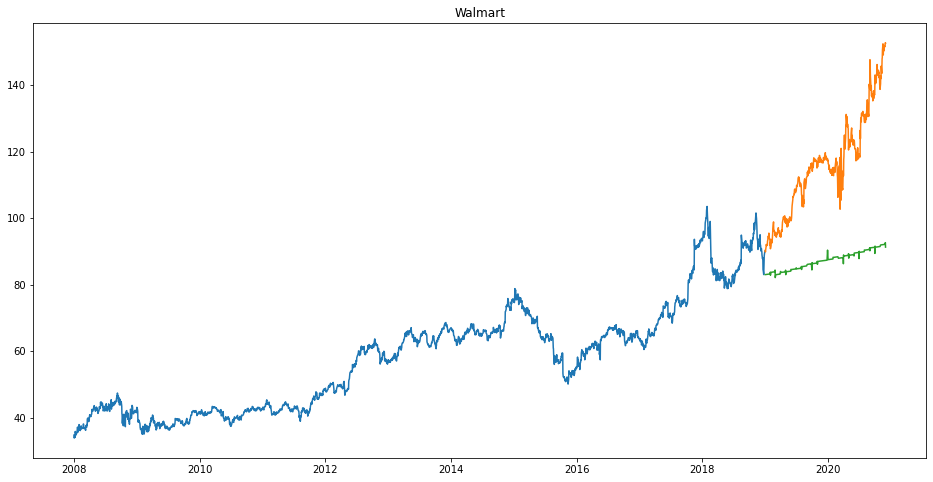

Amazon
 Root Mean Squared Error = 1058.3905444399752 
 Mean Absolute Error = 925.6250949683777 




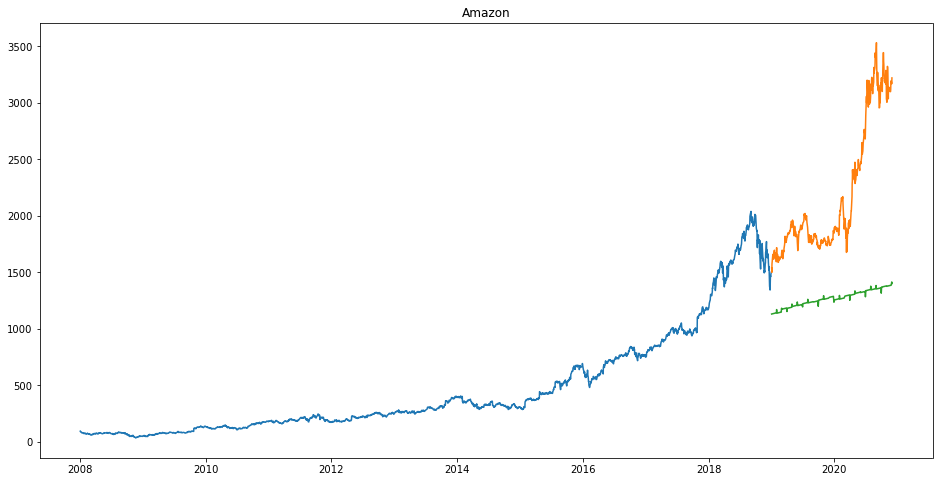

Mastercard
 Root Mean Squared Error = 118.85482784655052 
 Mean Absolute Error = 114.1322514729243 




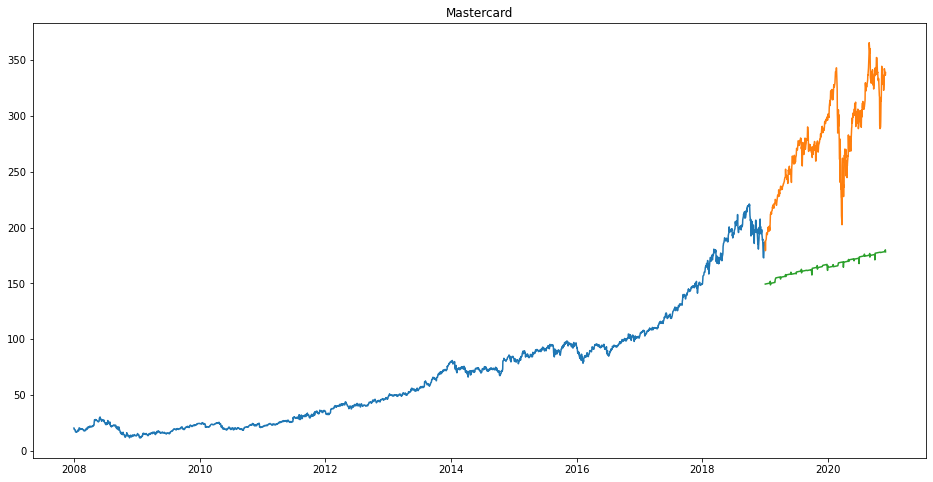

Visa
 Root Mean Squared Error = 58.17196110271006 
 Mean Absolute Error = 56.07476840524501 




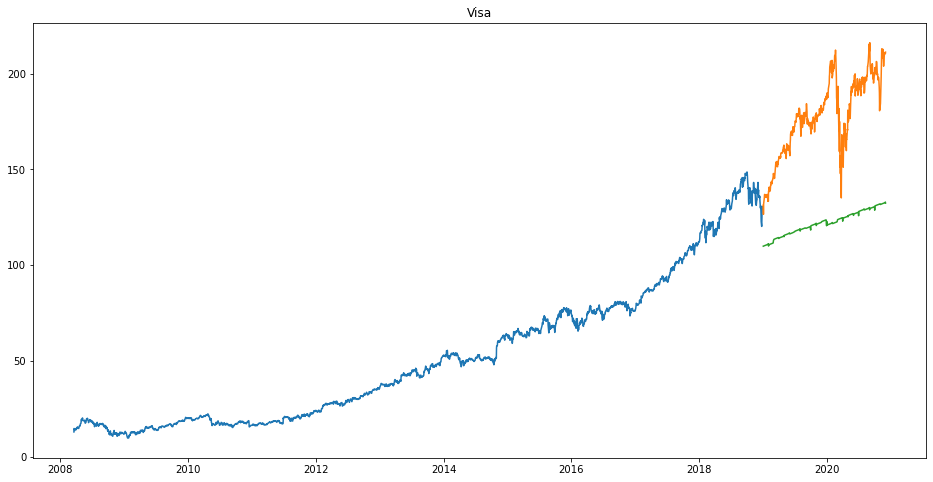

Netflix
 Root Mean Squared Error = 168.91423188147843 
 Mean Absolute Error = 154.06420888005772 




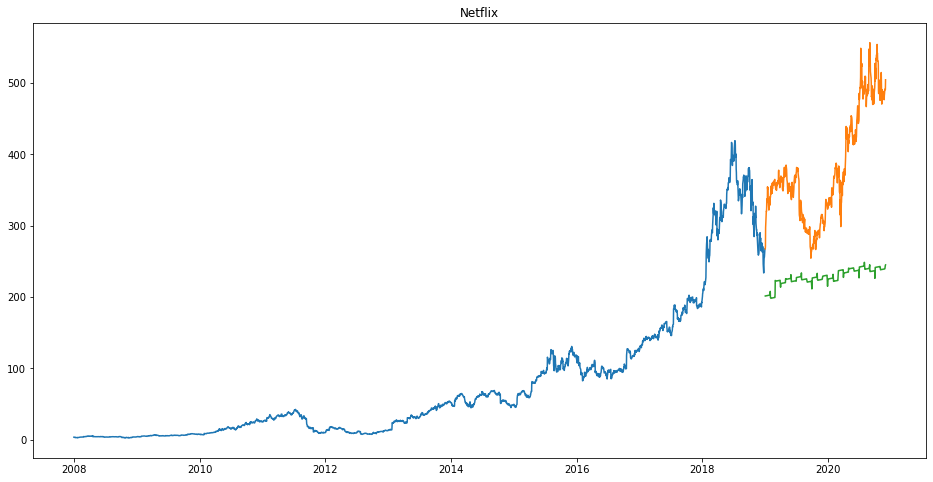

Disney
 Root Mean Squared Error = 15.518901957708659 
 Mean Absolute Error = 13.435995214074643 




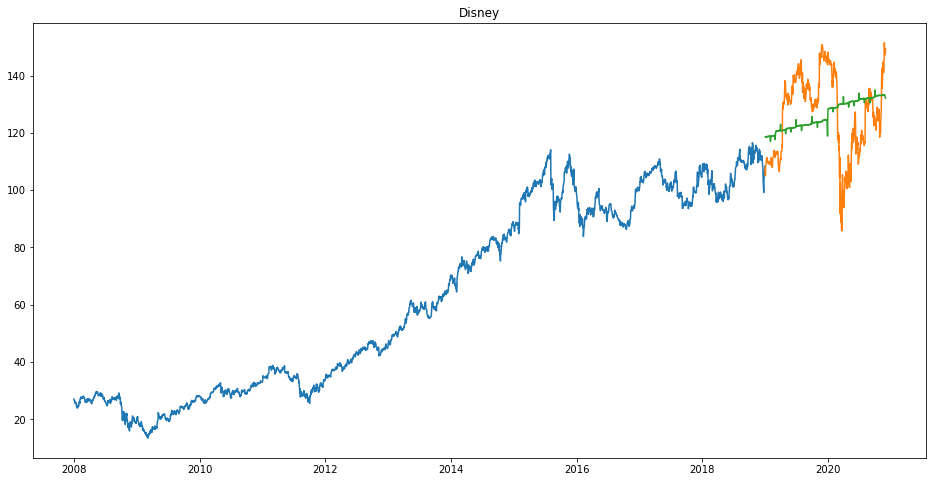

Pfizer
 Root Mean Squared Error = 3.4243214439908587 
 Mean Absolute Error = 2.95761920661348 




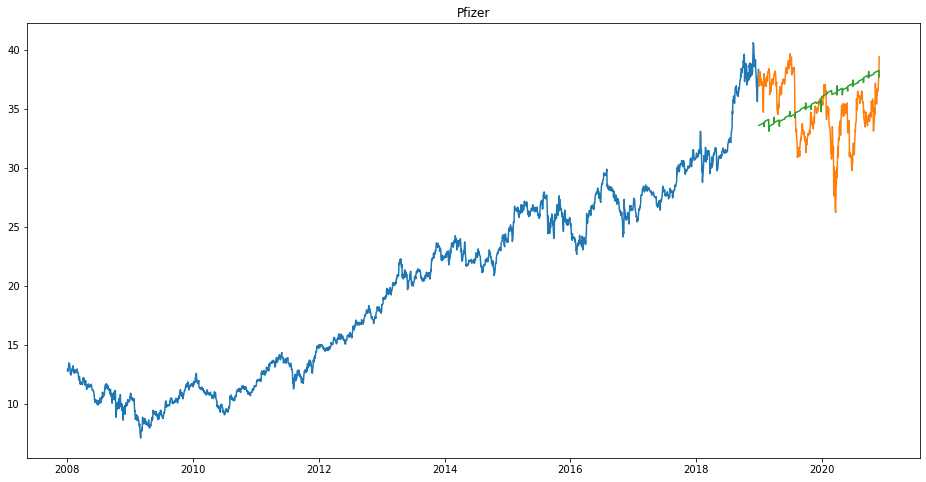

Novavax
 Root Mean Squared Error = 62.12088949123047 
 Mean Absolute Error = 57.502097477243055 




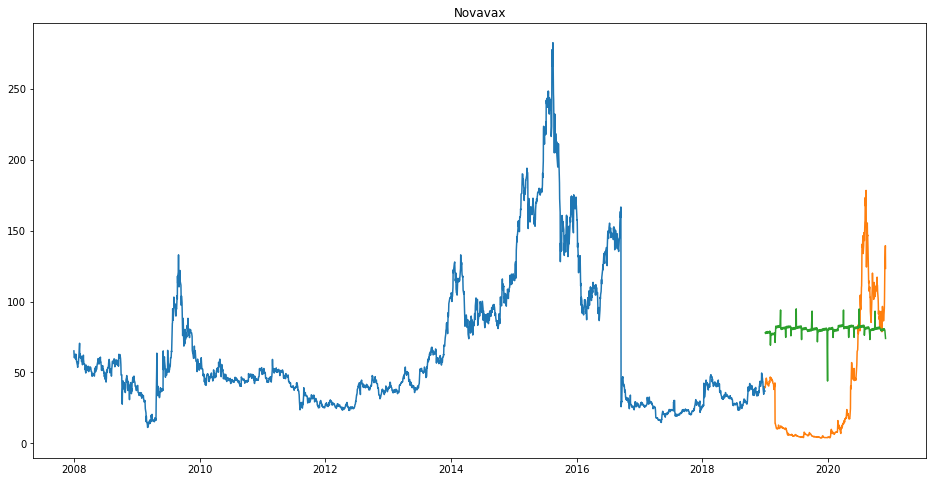

In [14]:
#Linear Regression SUPERVISED

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import numpy as np

model = LinearRegression()

for category in DATA.keys():
    for symb in DATA[category]:
        model.fit(X_train[symb], y_train[symb])
        preds = model.predict(X_test[symb])
        rmse = np.sqrt(mean_squared_error(y_test[symb]['Close'], preds))
        mae = mean_absolute_error(y_test[symb]['Close'], preds)
        
        print('{}\n Root Mean Squared Error = {} \n Mean Absolute Error = {} \n\n'.format('\033[1m' + symb + '\033[0;0m', rmse, mae))
        
        y_test[symb]['Predictions'] = preds
        
        #Uncomment and print the graphs
        
        plt.figure(figsize=(16,8))
        plt.plot(y_train[symb]['Close'])
        plt.plot(y_test[symb][['Close', 'Predictions']])
        plt.title(symb)
        plt.show()
        
        y_test[symb].drop('Predictions', axis=1, inplace=True)

###  <span style='color:Maroon'> 6.2 Long Short Term Memory  </span>
<p style='color:Gray'>  It is a powerful unsupervised algorithm in prediction problems where sequence is involved. In addition to processing single data points, it also processes the sequences of data. This is important in the case of stock prediction as the previous price of a stock is crucial in predicting its future price. Thus, the ability for LSTM to remember information over a long period of time makes them better suited for predicting stock prices over classification or association. </p>

Walmart

Epoch 1/10
80/80 [==============================] - 5s 61ms/step - loss: 0.0083
Epoch 2/10
80/80 [==============================] - 6s 76ms/step - loss: 6.5769e-04
Epoch 3/10
80/80 [==============================] - 7s 82ms/step - loss: 6.1767e-04
Epoch 4/10
80/80 [==============================] - 5s 66ms/step - loss: 5.6437e-04
Epoch 5/10
80/80 [==============================] - 6s 76ms/step - loss: 5.5424e-04
Epoch 6/10
80/80 [==============================] - 6s 69ms/step - loss: 5.5488e-04
Epoch 7/10
80/80 [==============================] - 6s 73ms/step - loss: 4.7236e-04
Epoch 8/10
80/80 [==============================] - 7s 90ms/step - loss: 5.1706e-04
Epoch 9/10
80/80 [==============================] - 8s 95ms/step - loss: 4.5675e-04
Epoch 10/10
80/80 [==============================] - 7s 82ms/step - loss: 4.6830e-04

Root Mean Squared Error: 3.8322437820061186
Mean Absolute Error: 2.6401707144486393


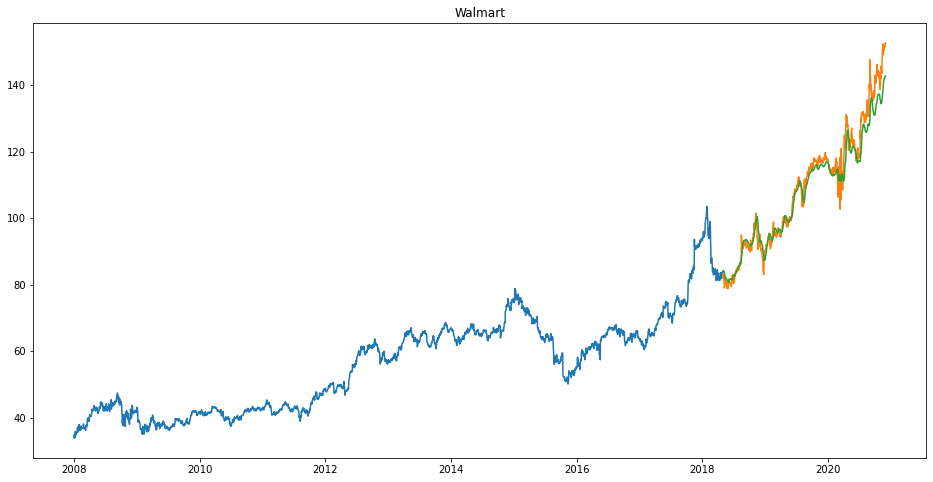

Amazon

Epoch 1/10
80/80 [==============================] - 5s 62ms/step - loss: 0.0050
Epoch 2/10
80/80 [==============================] - 5s 63ms/step - loss: 2.8323e-04
Epoch 3/10
80/80 [==============================] - 5s 61ms/step - loss: 2.9069e-04
Epoch 4/10
80/80 [==============================] - 5s 61ms/step - loss: 2.6928e-04
Epoch 5/10
80/80 [==============================] - 6s 70ms/step - loss: 2.9619e-04
Epoch 6/10
80/80 [==============================] - 5s 64ms/step - loss: 2.5273e-04
Epoch 7/10
80/80 [==============================] - 5s 59ms/step - loss: 2.7873e-04
Epoch 8/10
80/80 [==============================] - 5s 59ms/step - loss: 3.1191e-04
Epoch 9/10
80/80 [==============================] - 5s 59ms/step - loss: 2.5537e-04
Epoch 10/10
80/80 [==============================] - 7s 91ms/step - loss: 2.6169e-04

Root Mean Squared Error: 181.3190327379591
Mean Absolute Error: 116.87797625741769


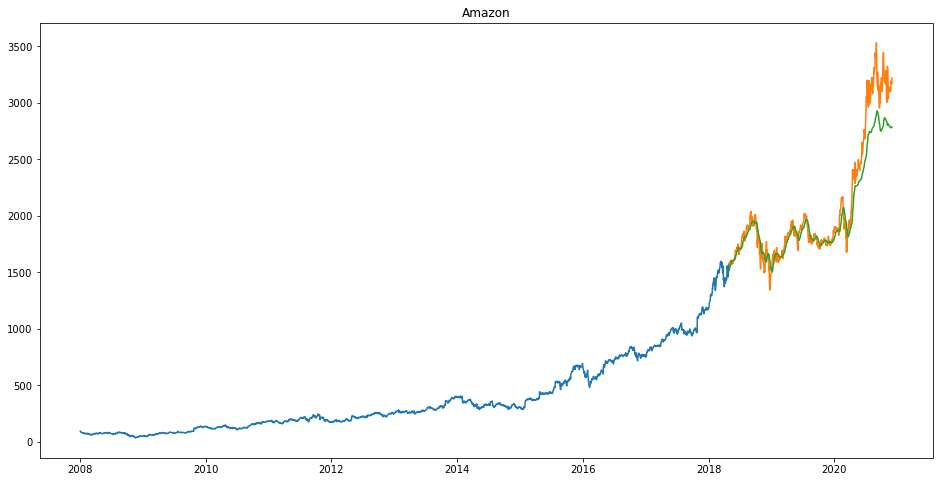

Mastercard

Epoch 1/10
80/80 [==============================] - 6s 75ms/step - loss: 0.0054
Epoch 2/10
80/80 [==============================] - 6s 70ms/step - loss: 3.2142e-04
Epoch 3/10
80/80 [==============================] - 5s 58ms/step - loss: 2.5478e-04
Epoch 4/10
80/80 [==============================] - 5s 64ms/step - loss: 2.7091e-04
Epoch 5/10
80/80 [==============================] - 5s 65ms/step - loss: 2.5453e-04
Epoch 6/10
80/80 [==============================] - 6s 70ms/step - loss: 2.3757e-04
Epoch 7/10
80/80 [==============================] - 4s 54ms/step - loss: 2.7854e-04
Epoch 8/10
80/80 [==============================] - 4s 54ms/step - loss: 2.3664e-04
Epoch 9/10
80/80 [==============================] - 6s 74ms/step - loss: 2.2011e-04
Epoch 10/10
80/80 [==============================] - 5s 59ms/step - loss: 2.4690e-04

Root Mean Squared Error: 20.118123842269505
Mean Absolute Error: 15.057538152625346


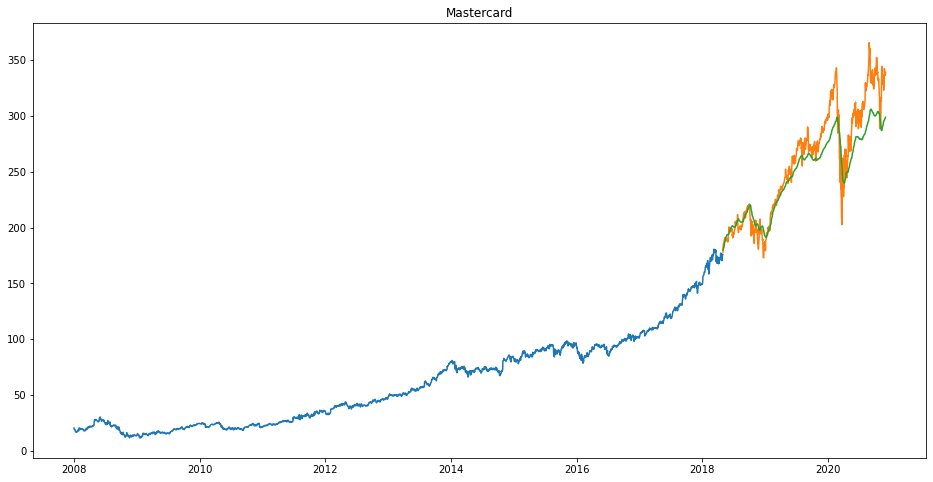

Visa

Epoch 1/10
80/80 [==============================] - 5s 63ms/step - loss: 0.0076
Epoch 2/10
80/80 [==============================] - 7s 91ms/step - loss: 3.0032e-04
Epoch 3/10
80/80 [==============================] - 6s 78ms/step - loss: 2.8442e-04
Epoch 4/10
80/80 [==============================] - 6s 80ms/step - loss: 2.9165e-04
Epoch 5/10
80/80 [==============================] - 6s 75ms/step - loss: 2.8690e-04
Epoch 6/10
80/80 [==============================] - 6s 69ms/step - loss: 2.8662e-04
Epoch 7/10
80/80 [==============================] - 5s 57ms/step - loss: 2.8333e-04
Epoch 8/10
80/80 [==============================] - 6s 80ms/step - loss: 2.8390e-04
Epoch 9/10
80/80 [==============================] - 5s 64ms/step - loss: 2.9228e-04
Epoch 10/10
80/80 [==============================] - 5s 63ms/step - loss: 3.1310e-04

Root Mean Squared Error: 7.650755353839524
Mean Absolute Error: 5.572978812217082


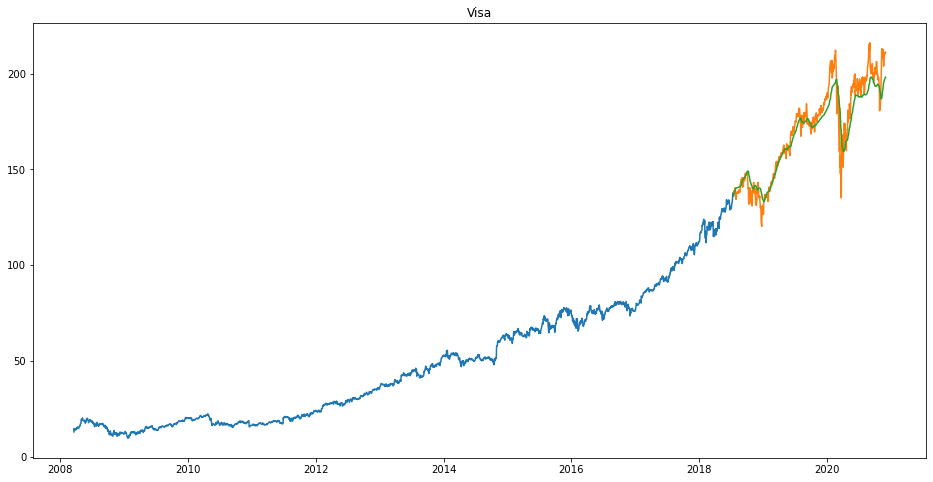

Netflix

Epoch 1/10
80/80 [==============================] - 6s 76ms/step - loss: 0.0038
Epoch 2/10
80/80 [==============================] - 5s 67ms/step - loss: 4.6515e-04
Epoch 3/10
80/80 [==============================] - 6s 70ms/step - loss: 4.2081e-04
Epoch 4/10
80/80 [==============================] - 6s 70ms/step - loss: 4.1093e-04
Epoch 5/10
80/80 [==============================] - 5s 64ms/step - loss: 4.4402e-04
Epoch 6/10
80/80 [==============================] - 5s 68ms/step - loss: 3.8413e-04
Epoch 7/10
80/80 [==============================] - 6s 70ms/step - loss: 3.4344e-04
Epoch 8/10
80/80 [==============================] - 6s 74ms/step - loss: 3.4025e-04
Epoch 9/10
80/80 [==============================] - 6s 69ms/step - loss: 3.4720e-04
Epoch 10/10
80/80 [==============================] - 7s 91ms/step - loss: 2.7640e-04

Root Mean Squared Error: 18.66024753711939
Mean Absolute Error: 13.767401044533045


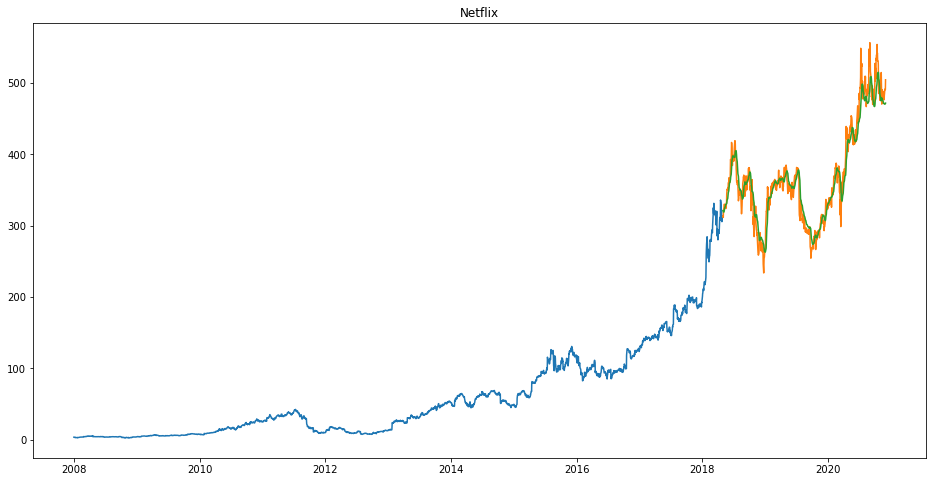

Disney

Epoch 1/10
80/80 [==============================] - 5s 62ms/step - loss: 0.0192
Epoch 2/10
80/80 [==============================] - 6s 77ms/step - loss: 8.2519e-04
Epoch 3/10
80/80 [==============================] - 6s 74ms/step - loss: 7.6666e-04
Epoch 4/10
80/80 [==============================] - 5s 64ms/step - loss: 7.2938e-04
Epoch 5/10
80/80 [==============================] - 5s 67ms/step - loss: 7.0936e-04
Epoch 6/10
80/80 [==============================] - 6s 74ms/step - loss: 6.4437e-04
Epoch 7/10
80/80 [==============================] - 6s 69ms/step - loss: 5.8250e-04
Epoch 8/10
80/80 [==============================] - 6s 71ms/step - loss: 6.1487e-04
Epoch 9/10
80/80 [==============================] - 6s 80ms/step - loss: 6.0935e-04
Epoch 10/10
80/80 [==============================] - 5s 65ms/step - loss: 5.9945e-04

Root Mean Squared Error: 8.759325613087036
Mean Absolute Error: 7.229578193184188


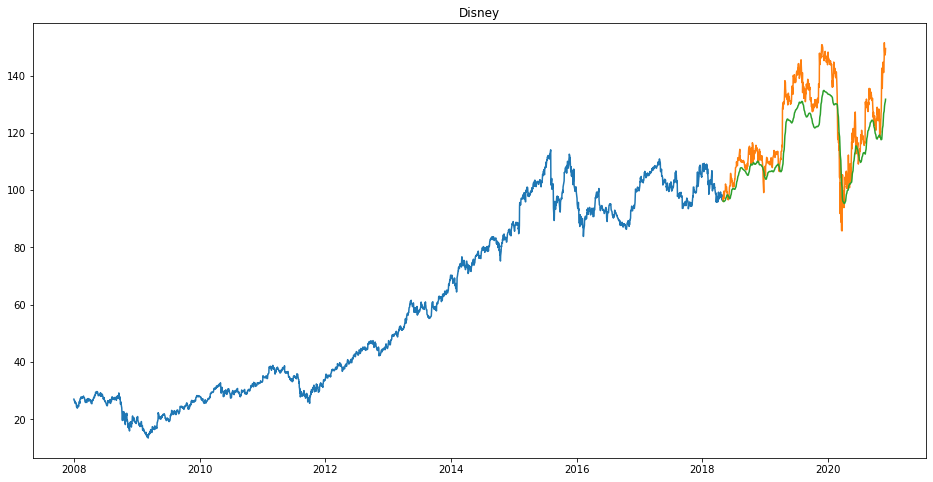

Pfizer

Epoch 1/10
80/80 [==============================] - 6s 75ms/step - loss: 0.0170
Epoch 2/10
80/80 [==============================] - 5s 61ms/step - loss: 7.8654e-04
Epoch 3/10
80/80 [==============================] - 5s 64ms/step - loss: 7.4944e-04
Epoch 4/10
80/80 [==============================] - 5s 58ms/step - loss: 7.3118e-04
Epoch 5/10
80/80 [==============================] - 5s 69ms/step - loss: 6.3574e-04
Epoch 6/10
80/80 [==============================] - 5s 67ms/step - loss: 6.4990e-04
Epoch 7/10
80/80 [==============================] - 5s 66ms/step - loss: 7.2518e-04
Epoch 8/10
80/80 [==============================] - 6s 70ms/step - loss: 6.4354e-04
Epoch 9/10
80/80 [==============================] - 5s 68ms/step - loss: 6.1926e-04
Epoch 10/10
80/80 [==============================] - 5s 67ms/step - loss: 5.7000e-04

Root Mean Squared Error: 1.5491559345259938
Mean Absolute Error: 1.3472925924417718


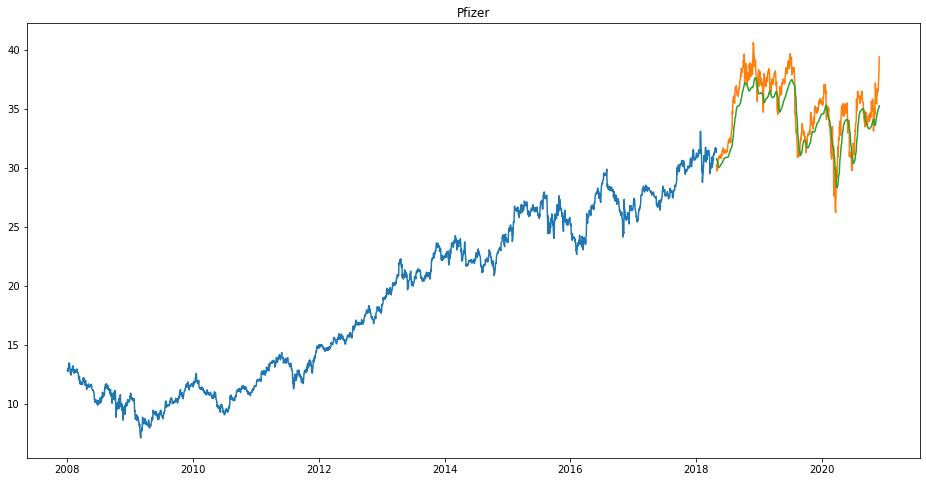

Novavax

Epoch 1/10
80/80 [==============================] - 6s 70ms/step - loss: 0.0049
Epoch 2/10
80/80 [==============================] - 5s 64ms/step - loss: 0.0013
Epoch 3/10
80/80 [==============================] - 5s 69ms/step - loss: 0.0012
Epoch 4/10
80/80 [==============================] - 5s 62ms/step - loss: 0.0011
Epoch 5/10
80/80 [==============================] - 6s 76ms/step - loss: 9.7873e-04
Epoch 6/10
80/80 [==============================] - 5s 64ms/step - loss: 9.7060e-04
Epoch 7/10
80/80 [==============================] - 5s 64ms/step - loss: 8.4005e-04
Epoch 8/10
80/80 [==============================] - 5s 66ms/step - loss: 8.0072e-04
Epoch 9/10
80/80 [==============================] - 5s 69ms/step - loss: 8.1749e-04
Epoch 10/10
80/80 [==============================] - 6s 71ms/step - loss: 7.6864e-04

Root Mean Squared Error: 6.037957081985636
Mean Absolute Error: 3.556671881723915


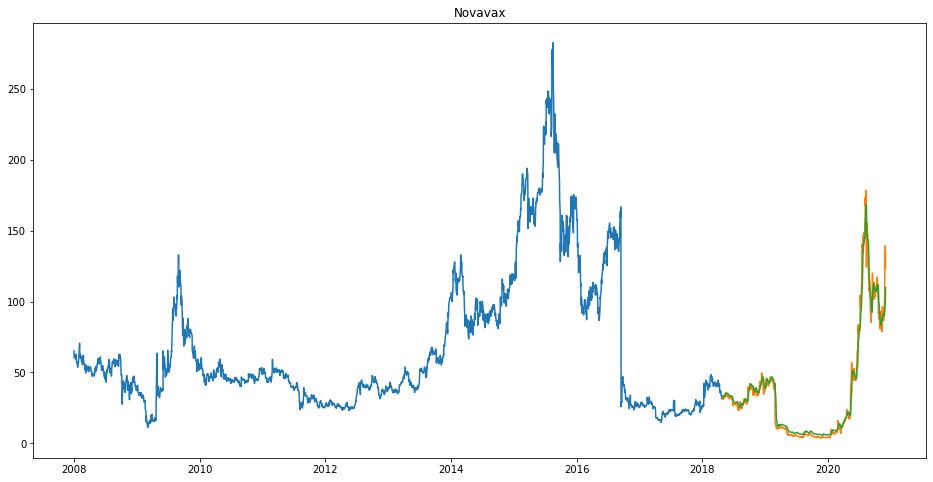

In [16]:
#LSTM UNSUPERVISED

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def get_model():
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

train = dict()
test = dict()
sc = MinMaxScaler(feature_range = (0, 1))

for category in DATA.keys():
    for symb in DATA[category]:
        df = train_dict[symb]
        df = df.sort_index(ascending=True, axis=0)
        train[symb] = df.iloc[:2600,1:2].values
        test[symb] = df.iloc[2600:,1:2].values

        train[symb] = sc.fit_transform(train[symb])
        
        X_train = []
        y_train = []
        
        for i in range(60, 2600):
            X_train.append(train[symb][i-60:i, 0])
            y_train.append(train[symb][i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        
        print('\033[1m' + symb + '\033[0;0m' + '\n')


        model = get_model()
        model.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose = 1)
        
        inputs = df.iloc[len(df)-len(test[symb])-60:,1:2].values
        inputs = inputs.reshape(-1,1)
        inputs  = sc.transform(inputs)
        
        X_test = []
        for i in range(60,inputs.shape[0]):
            X_test.append(inputs[i-60:i,0])
        X_test = np.array(X_test)

        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
        closing_price = model.predict(X_test)
        closing_price = sc.inverse_transform(closing_price)
        
        
        rmse=np.sqrt(np.mean(np.power((test[symb]-closing_price),2)))
        mae = np.mean(np.abs(test[symb]-closing_price))
        
        print('\nRoot Mean Squared Error: {}'.format(rmse))
        print('Mean Absolute Error: {}'.format(mae))
        
        closing_price = np.reshape(closing_price, (closing_price.shape[0]))
        y_test = df[['Close']].iloc[2600:].copy(deep=True)
        y_test['Predictions'] = closing_price

        plt.figure(figsize=(16,8))
        plt.plot(df['Close'].iloc[:2600])
        plt.plot(y_test[['Close', 'Predictions']])
        plt.title(symb)
        plt.show()
        